### Importing Packages and API Key

In [5]:
# Import packages
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
from dotenv import load_dotenv
from scipy import stats

# Load environment variables from the .env file
load_dotenv('../config.env')


True

In [6]:
# Import MlFinLab package
import mlfinlab
from mlfinlab.data_structures.standard_data_structures import (get_dollar_bars,
                                                               get_tick_bars, get_volume_bars)

from mlfinlab.multi_product.etf_trick import get_futures_roll_series

<frozen mlfinlab.util.fast_ewma>:17: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.


### Importing Data and Creating Dollar, Volume and Tick Bars

In [7]:
# import ES_Trades data
path = '../Data/ES_Trades.csv'
data = pd.read_csv(path)

# viewing data
data.head()


,Symbol,Date,Time,Price,Volume,Market Flag,Sales Condition,Exclude Record Flag,Unfiltered Price
0,ESU13,09/01/2013,17:00:00.083,1640.25,8,E,0,NaN,1640.25
1,ESU13,09/01/2013,17:00:00.083,1640.25,1,E,0,NaN,1640.25
2,ESU13,09/01/2013,17:00:00.083,1640.25,2,E,0,NaN,1640.25
3,ESU13,09/01/2013,17:00:00.083,1640.25,1,E,0,NaN,1640.25
4,ESU13,09/01/2013,17:00:00.083,1640.25,1,E,0,NaN,1640.25


In [8]:
# get all unique values of the 'Symbol' column

data['Date'].unique()

array(['09/01/2013', '09/02/2013', '09/03/2013', '09/04/2013',
       '09/05/2013', '09/06/2013', '09/08/2013', '09/09/2013',
       '09/10/2013', '09/11/2013', '09/12/2013', '09/13/2013',
       '09/15/2013', '09/16/2013', '09/17/2013', '09/18/2013',
       '09/19/2013', '09/20/2013'], dtype=object)

In [9]:
# Format the Data
date_time = data['Date'] + ' ' + data['Time'] # Dont convert to datetime here, it will take forever to convert.
new_data = pd.concat([date_time, data['Price'], data['Volume']], axis=1)
new_data.columns = ['date', 'price', 'volume']
print(new_data.head())
print('\n')
print('Rows:', new_data.shape[0])


                      date    price  volume
0  09/01/2013 17:00:00.083  1640.25       8
1  09/01/2013 17:00:00.083  1640.25       1
2  09/01/2013 17:00:00.083  1640.25       2
3  09/01/2013 17:00:00.083  1640.25       1
4  09/01/2013 17:00:00.083  1640.25       1


Rows: 5454950


In [10]:
# saving data to CSV in Data folder. This is in order to save processing time in production. All MFinLab functions take the saved data path as input in order not to hold it in memory.

#new_data.to_csv('Data/ES_Trades_Formatted.csv', index=False)


In [11]:
# 'new_data' can be simply replaced with the file path where 'raw_tick_data' was saved if memory is an issue
print('Creating Dollar Bars')
dollar = get_dollar_bars(new_data, threshold=75000000,
                         batch_size=1000000, verbose=True)

print('Creating Volume Bars')
volume = get_volume_bars(new_data, threshold=50000,
                         batch_size=1000000, verbose=False)

print('Creating Tick Bars')
tick = get_tick_bars(new_data, threshold=7500,
                     batch_size=1000000, verbose=False)


Creating Dollar Bars
Reading data in batches:
Batch number: 0
Batch number: 1
Batch number: 2
Batch number: 3
Batch number: 4
Batch number: 5
Returning bars 

Creating Volume Bars
Creating Tick Bars


### Confirming Sampling

In [12]:
# Confirm the dollar sampling
dollar['value'] = dollar['close'] * dollar['volume']
dollar.head()


,tick_num,open,high,low,close,volume,cum_buy_volume,cum_ticks,cum_dollar_value,value
date_time,,,,,,,,,,
09/01/2013 22:39:31.743,12388,1640.25,1643.50,1639.00,1642.75,45701,23728,12388,75007533.75,75075317.75
09/02/2013 03:21:48.165,28825,1642.75,1646.00,1642.00,1645.50,45681,25727,16437,75103229.75,75168085.50
09/02/2013 06:52:21.039,42634,1645.50,1648.50,1645.25,1646.75,45551,25683,13809,75006194.00,75011109.25
09/02/2013 10:12:53.277,54178,1646.75,1648.25,1645.25,1647.75,45539,25051,11544,75003419.75,75036887.25
09/03/2013 01:19:41.222,68780,1647.75,1649.00,1645.25,1648.25,45535,24250,14602,75009393.25,75053063.75


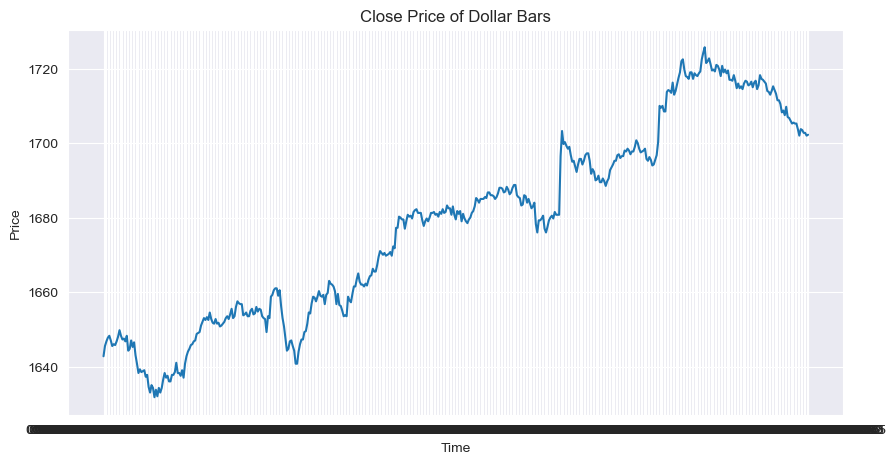

In [13]:
# plotting close price of dollar bars
plt.figure(figsize=(10, 5))
plt.plot(dollar.index, dollar['close'])
plt.title('Close Price of Dollar Bars')
plt.xlabel('Time')
plt.ylabel('Price')

# showig the plot
plt.show()

In [14]:
# Confirm the value sampling
volume.head()


,tick_num,open,high,low,close,volume,cum_buy_volume,cum_ticks,cum_dollar_value
date_time,,,,,,,,,
09/02/2013 00:06:21.778,13953,1640.25,1644.00,1639.00,1642.50,50000,26134,13953,82070721.00
09/02/2013 03:52:13.007,31829,1642.50,1647.25,1642.00,1647.00,50000,28763,17876,82228815.25
09/02/2013 07:55:16.431,45507,1647.00,1648.50,1645.25,1647.00,50000,27966,13678,82345915.25
09/02/2013 19:36:41.948,60031,1647.00,1648.50,1645.25,1647.00,50006,26147,14524,82351850.75
09/03/2013 02:32:56.009,76581,1647.00,1649.00,1646.00,1647.75,50000,26229,16550,82376189.75


In [15]:
# viewing the tick sampling

tick.head()

,tick_num,open,high,low,close,volume,cum_buy_volume,cum_ticks,cum_dollar_value
date_time,,,,,,,,,
09/01/2013 19:48:21.282,7500,1640.25,1642.00,1639.00,1642.00,29387,16517,7500,48218298.50
09/02/2013 01:00:34.717,15000,1642.00,1644.00,1640.25,1643.00,23616,11264,7500,38785190.25
09/02/2013 02:25:26.765,22500,1643.00,1645.00,1642.25,1644.75,20856,11737,7500,34282832.75
09/02/2013 03:33:18.103,30000,1644.75,1646.75,1643.75,1646.50,20945,12439,7500,34457010.25
09/02/2013 05:36:01.900,37500,1646.50,1647.25,1645.25,1647.00,22510,11059,7500,37056813.00


### Creating a Continuous Futures Contract using the ETF Trick

In [16]:
# making a copy of  dollar, tick, volume bars
dollar_roll = dollar.copy()
tick_roll = tick.copy()
volume_roll = volume.copy()

# Ensure the index is a datetime object for each of the dataframes
dollar_roll.index = pd.to_datetime(dollar_roll.index)
tick_roll.index = pd.to_datetime(tick_roll.index)
volume_roll.index = pd.to_datetime(volume_roll.index)

# adding a date column to dollar_roll, tick and volume bars
dollar_roll['date'] = dollar_roll.index.date
tick_roll['date'] = tick_roll.index.date
volume_roll['date'] = volume_roll.index.date

# selecting only the columns we need for the ETF trick: 'date', 'date_time', 'close', 'open', 'high', 'low', 'volume' for each dataframe
dollar_roll = dollar_roll[['date', 'close', 'open', 'high', 'low', 'volume']]
tick_roll = tick_roll[['date', 'close', 'open', 'high', 'low', 'volume']]
volume_roll = volume_roll[['date', 'close', 'open', 'high', 'low', 'volume']]

# adding a ticker column to dollar_roll with the value 'ES' for each dataframe from above
dollar_roll['ticker'] = 'ES'
tick_roll['ticker'] = 'ES'
volume_roll['ticker'] = 'ES'

# adding a nearest_contract column to dollar_roll with the value 'ES' for each dataframe from above
dollar_roll['nearest_contract'] = 'ES'
tick_roll['nearest_contract'] = 'ES'
volume_roll['nearest_contract'] = 'ES'


In [17]:
# Get roll gaps (relative or absolute)

# for dollar_roll
roll_gaps_relative_dollar = get_futures_roll_series(dollar_roll, open_col='open', close_col='close',
                                             sec_col='ticker', current_sec_col='nearest_contract', method='relative')

# for tick_roll
roll_gaps_relative_tick = get_futures_roll_series(tick_roll, open_col='open', close_col='close',
                                             sec_col='ticker', current_sec_col='nearest_contract', method='relative')

# for volume_roll
roll_gaps_relative_volume = get_futures_roll_series(volume_roll, open_col='open', close_col='close',
                                             sec_col='ticker', current_sec_col='nearest_contract', method='relative')

In [18]:
# apply the roll gaps
continuous_dollar_relative_method = dollar_roll.copy()
continuous_dollar_relative_method['close'] /= roll_gaps_relative_dollar

# apply for tick_roll
continuous_tick_relative_method = tick_roll.copy()
continuous_tick_relative_method['close'] /= roll_gaps_relative_tick

# apply for volume_roll
continuous_volume_relative_method = volume_roll.copy()
continuous_volume_relative_method['close'] /= roll_gaps_relative_volume



In [19]:
# viewing the head of continuous_contract_relative_method
continuous_dollar_relative_method.head()


,date,close,open,high,low,volume,ticker,nearest_contract
date_time,,,,,,,,
2013-09-01 22:39:31.743,2013-09-01,1642.75,1640.25,1643.50,1639.00,45701,ES,ES
2013-09-02 03:21:48.165,2013-09-02,1645.50,1642.75,1646.00,1642.00,45681,ES,ES
2013-09-02 06:52:21.039,2013-09-02,1646.75,1645.50,1648.50,1645.25,45551,ES,ES
2013-09-02 10:12:53.277,2013-09-02,1647.75,1646.75,1648.25,1645.25,45539,ES,ES
2013-09-03 01:19:41.222,2013-09-03,1648.25,1647.75,1649.00,1645.25,45535,ES,ES


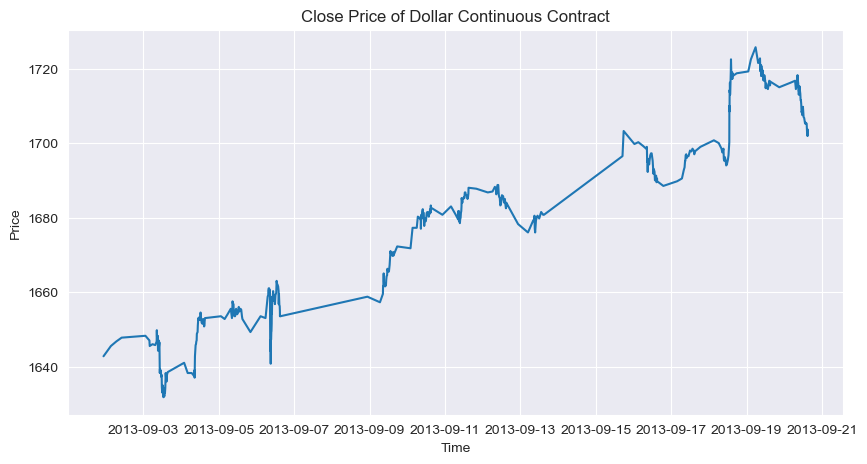

In [20]:
# plotting the close price of the continuous contract with x-axis as 'date_time' and y-axis as 'close' for each of the continuous contracts

# for dollar
plt.figure(figsize=(10, 5))
plt.plot(continuous_dollar_relative_method.index ,continuous_dollar_relative_method['close'])
plt.title('Close Price of Dollar Continuous Contract')
plt.xlabel('Time')
plt.ylabel('Price')
plt.show()


In [21]:
#viewing the head of continuous_tick_relative_method
continuous_tick_relative_method.head()


,date,close,open,high,low,volume,ticker,nearest_contract
date_time,,,,,,,,
2013-09-01 19:48:21.282,2013-09-01,1642.00,1640.25,1642.00,1639.00,29387,ES,ES
2013-09-02 01:00:34.717,2013-09-02,1643.00,1642.00,1644.00,1640.25,23616,ES,ES
2013-09-02 02:25:26.765,2013-09-02,1644.75,1643.00,1645.00,1642.25,20856,ES,ES
2013-09-02 03:33:18.103,2013-09-02,1646.50,1644.75,1646.75,1643.75,20945,ES,ES
2013-09-02 05:36:01.900,2013-09-02,1647.00,1646.50,1647.25,1645.25,22510,ES,ES


In [22]:
# viewing the head of continuous_volume_relative_method
continuous_volume_relative_method.head()

,date,close,open,high,low,volume,ticker,nearest_contract
date_time,,,,,,,,
2013-09-02 00:06:21.778,2013-09-02,1642.50,1640.25,1644.00,1639.00,50000,ES,ES
2013-09-02 03:52:13.007,2013-09-02,1647.00,1642.50,1647.25,1642.00,50000,ES,ES
2013-09-02 07:55:16.431,2013-09-02,1647.00,1647.00,1648.50,1645.25,50000,ES,ES
2013-09-02 19:36:41.948,2013-09-02,1647.00,1647.00,1648.50,1645.25,50006,ES,ES
2013-09-03 02:32:56.009,2013-09-03,1647.75,1647.00,1649.00,1646.00,50000,ES,ES


In [23]:
# producing 3 dataframe to count the number of bars in each continuous contract by week using the date column

# Ensure the date columns are datetime objects
continuous_dollar_relative_method['date'] = pd.to_datetime(continuous_dollar_relative_method['date'])
continuous_tick_relative_method['date'] = pd.to_datetime(continuous_tick_relative_method['date'])
continuous_volume_relative_method['date'] = pd.to_datetime(continuous_volume_relative_method['date'])

# Create a week column in each dataframe from the date column
continuous_dollar_relative_method['week'] = continuous_dollar_relative_method['date'].dt.isocalendar().week
continuous_tick_relative_method['week'] = continuous_tick_relative_method['date'].dt.isocalendar().week
continuous_volume_relative_method['week'] = continuous_volume_relative_method['date'].dt.isocalendar().week

# creating a count column in each dataframe
dollar_count = continuous_dollar_relative_method.groupby('week').count()
tick_count = continuous_tick_relative_method.groupby('week').count()
volume_count = continuous_volume_relative_method.groupby('week').count()



Text(0.5, 0, 'Week')

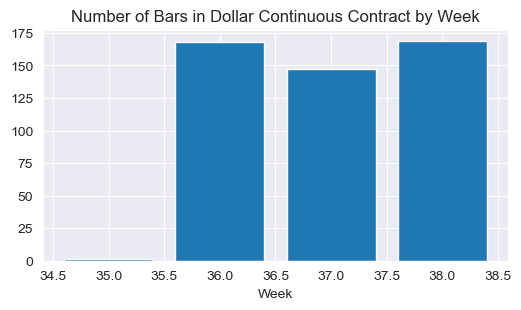

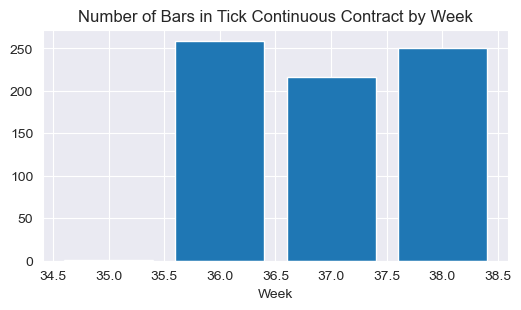

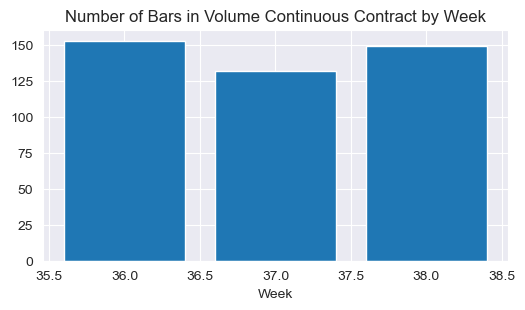

In [24]:
# plotining the number of bars in each continuous contract as a time series based on dataframes above. The plots should be bar plots with the x-axis as the week and the y-axis as the number of bars in each continuous contract.

# plot for dollar_count
plt.figure(figsize=(6, 3))
plt.bar(dollar_count.index, dollar_count['close'])
plt.title('Number of Bars in Dollar Continuous Contract by Week')
plt.xlabel('Week')

# plot for tick_count
plt.figure(figsize=(6, 3))
plt.bar(tick_count.index, tick_count['close'])
plt.title('Number of Bars in Tick Continuous Contract by Week')
plt.xlabel('Week')

# plot for volume_count
plt.figure(figsize=(6, 3))
plt.bar(volume_count.index, volume_count['close'])
plt.title('Number of Bars in Volume Continuous Contract by Week')
plt.xlabel('Week')


In [25]:
# Calculate the variance of weekly bar counts for each method
dollar_weekly_variance = dollar_count['close'].var()
tick_weekly_variance = tick_count['close'].var()
volume_weekly_variance = volume_count['close'].var()

# Print the variances
print('Dollar Bars Weekly Variance:', dollar_weekly_variance)
print('Tick Bars Weekly Variance:', tick_weekly_variance)
print('Volume Bars Weekly Variance:', volume_weekly_variance)

# Determine the most stable method
most_stable_method = min(
    ('Dollar Bars', dollar_weekly_variance),
    ('Tick Bars', tick_weekly_variance),
    ('Volume Bars', volume_weekly_variance),
    key=lambda x: x[1]
)

print('Most Stable Method:', most_stable_method[0])

Dollar Bars Weekly Variance: 6529.583333333333
Tick Bars Weekly Variance: 14868.916666666666
Volume Bars Weekly Variance: 124.33333333333333
Most Stable Method: Volume Bars


### Calculating Statisticl Propeties of Returns (Serial Correlation, Variance, Jarque-Bera Normality Test)

#### Serial Correlation

In [26]:
# adding a returns column to each of the continuous contracts

# for dollar
continuous_dollar_relative_method['returns'] = continuous_dollar_relative_method['close'].pct_change()

# for tick
continuous_tick_relative_method['returns'] = continuous_tick_relative_method['close'].pct_change()

# for volume
continuous_volume_relative_method['returns'] = continuous_volume_relative_method['close'].pct_change()


In [27]:
# calculating the serial correlation of returns for each continuous contract
# for dollar
dollar_serial_corr = continuous_dollar_relative_method['returns'].autocorr()

# for tick
tick_serial_corr = continuous_tick_relative_method['returns'].autocorr()

# for volume
volume_serial_corr = continuous_volume_relative_method['returns'].autocorr()


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [28]:
# Testing which of the continuous contracts have the lowest serial correlation of returns
print('Dollar Serial Correlation:', dollar_serial_corr)
print('Tick Serial Correlation:', tick_serial_corr)
print('Volume Serial Correlation:', volume_serial_corr)


Dollar Serial Correlation: 0.04554303227172079
Tick Serial Correlation: 0.016958540807381125
Volume Serial Correlation: 0.0480925737700467


#### Variance

In [29]:
# Partioning each of the continuous contracts into weekly partitions by adding a week column to each of the dataframes

# for dollar
continuous_dollar_relative_method['week'] = continuous_dollar_relative_method['date'].dt.isocalendar().week

# for tick
continuous_tick_relative_method['week'] = continuous_tick_relative_method['date'].dt.isocalendar().week

# for volume
continuous_volume_relative_method['week'] = continuous_volume_relative_method['date'].dt.isocalendar().week

# Computing the variance of returns for each weekly partition of each continuous contract

# for dollar
dollar_variance = continuous_dollar_relative_method.groupby('week')['returns'].var()

# for tick
tick_variance = continuous_tick_relative_method.groupby('week')['returns'].var()

# for volume
volume_variance = continuous_volume_relative_method.groupby('week')['returns'].var()

# calculating the variacne of the above variances

# for dollar
dollar_variance_variance = dollar_variance.var()

# for tick
tick_variance_variance = tick_variance.var()

# for volume
volume_variance_variance = volume_variance.var()


In [30]:
# printing the variance of the variance of returns for each continuous contract
print('Dollar Variance Variance:', dollar_variance_variance)
print('Tick Variance Variance:', tick_variance_variance)
print('Volume Variance Variance:', volume_variance_variance)


Dollar Variance Variance: 5.204804494482205e-14
Tick Variance Variance: 1.4479212390869375e-14
Volume Variance Variance: 5.2442930994608594e-14


#### Jarque-Bera Normality Test

In [31]:
# applying the Jarque-Bera Normality Test to the returns of each continuous contract

# Check for missing values and remove them
continuous_dollar_relative_method['returns'].dropna(inplace=True)
continuous_tick_relative_method['returns'].dropna(inplace=True)
continuous_volume_relative_method['returns'].dropna(inplace=True)

# Check for infinite values and remove them
continuous_dollar_relative_method = continuous_dollar_relative_method[np.isfinite(continuous_dollar_relative_method['returns'])]
continuous_tick_relative_method = continuous_tick_relative_method[np.isfinite(continuous_tick_relative_method['returns'])]
continuous_volume_relative_method = continuous_volume_relative_method[np.isfinite(continuous_volume_relative_method['returns'])]

# Ensure there are enough data points
if len(continuous_dollar_relative_method['returns']) > 2:
    dollar_jarque_bera = stats.jarque_bera(continuous_dollar_relative_method['returns'])
else:
    dollar_jarque_bera = (np.nan, np.nan)

if len(continuous_tick_relative_method['returns']) > 2:
    tick_jarque_bera = stats.jarque_bera(continuous_tick_relative_method['returns'])
else:
    tick_jarque_bera = (np.nan, np.nan)

if len(continuous_volume_relative_method['returns']) > 2:
    volume_jarque_bera = stats.jarque_bera(continuous_volume_relative_method['returns'])
else:
    volume_jarque_bera = (np.nan, np.nan)


In [32]:
# Print the results
print('Dollar Jarque-Bera:', dollar_jarque_bera)
print('Tick Jarque-Bera:', tick_jarque_bera)
print('Volume Jarque-Bera:', volume_jarque_bera)


Dollar Jarque-Bera: SignificanceResult(statistic=3673.5666457512016, pvalue=0.0)
Tick Jarque-Bera: SignificanceResult(statistic=4924.117446518819, pvalue=0.0)
Volume Jarque-Bera: SignificanceResult(statistic=6566.681221314748, pvalue=0.0)


### Plotting the Distributions of Returns

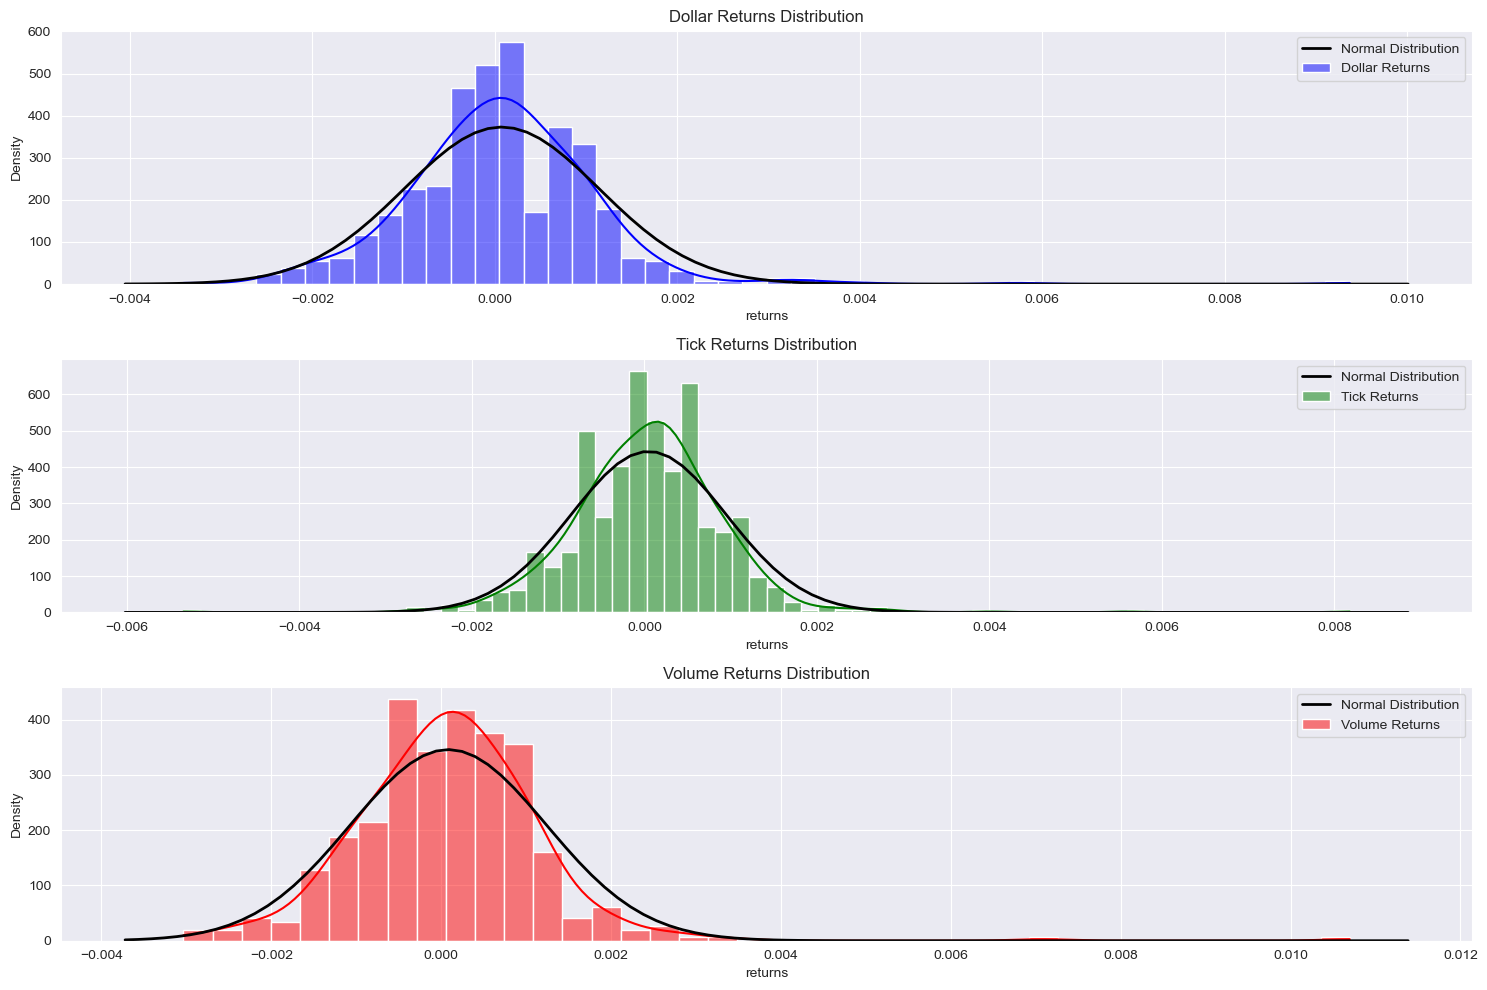

In [33]:

# Ensure the returns columns are clean
continuous_dollar_relative_method['returns'].dropna(inplace=True)
continuous_tick_relative_method['returns'].dropna(inplace=True)
continuous_volume_relative_method['returns'].dropna(inplace=True)

# Plotting the distributions
plt.figure(figsize=(15, 10))

# Dollar returns distribution
plt.subplot(3, 1, 1)
sns.histplot(continuous_dollar_relative_method['returns'], kde=True, stat="density", label='Dollar Returns', color='blue')
mean, std = stats.norm.fit(continuous_dollar_relative_method['returns'])
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, mean, std)
plt.plot(x, p, 'k', linewidth=2, label='Normal Distribution')
plt.title('Dollar Returns Distribution')
plt.legend()

# Tick returns distribution
plt.subplot(3, 1, 2)
sns.histplot(continuous_tick_relative_method['returns'], kde=True, stat="density", label='Tick Returns', color='green')
mean, std = stats.norm.fit(continuous_tick_relative_method['returns'])
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, mean, std)
plt.plot(x, p, 'k', linewidth=2, label='Normal Distribution')
plt.title('Tick Returns Distribution')
plt.legend()

# Volume returns distribution
plt.subplot(3, 1, 3)
sns.histplot(continuous_volume_relative_method['returns'], kde=True, stat="density", label='Volume Returns', color='red')
mean, std = stats.norm.fit(continuous_volume_relative_method['returns'])
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, mean, std)
plt.plot(x, p, 'k', linewidth=2, label='Normal Distribution')
plt.title('Volume Returns Distribution')
plt.legend()

plt.tight_layout()
plt.show()

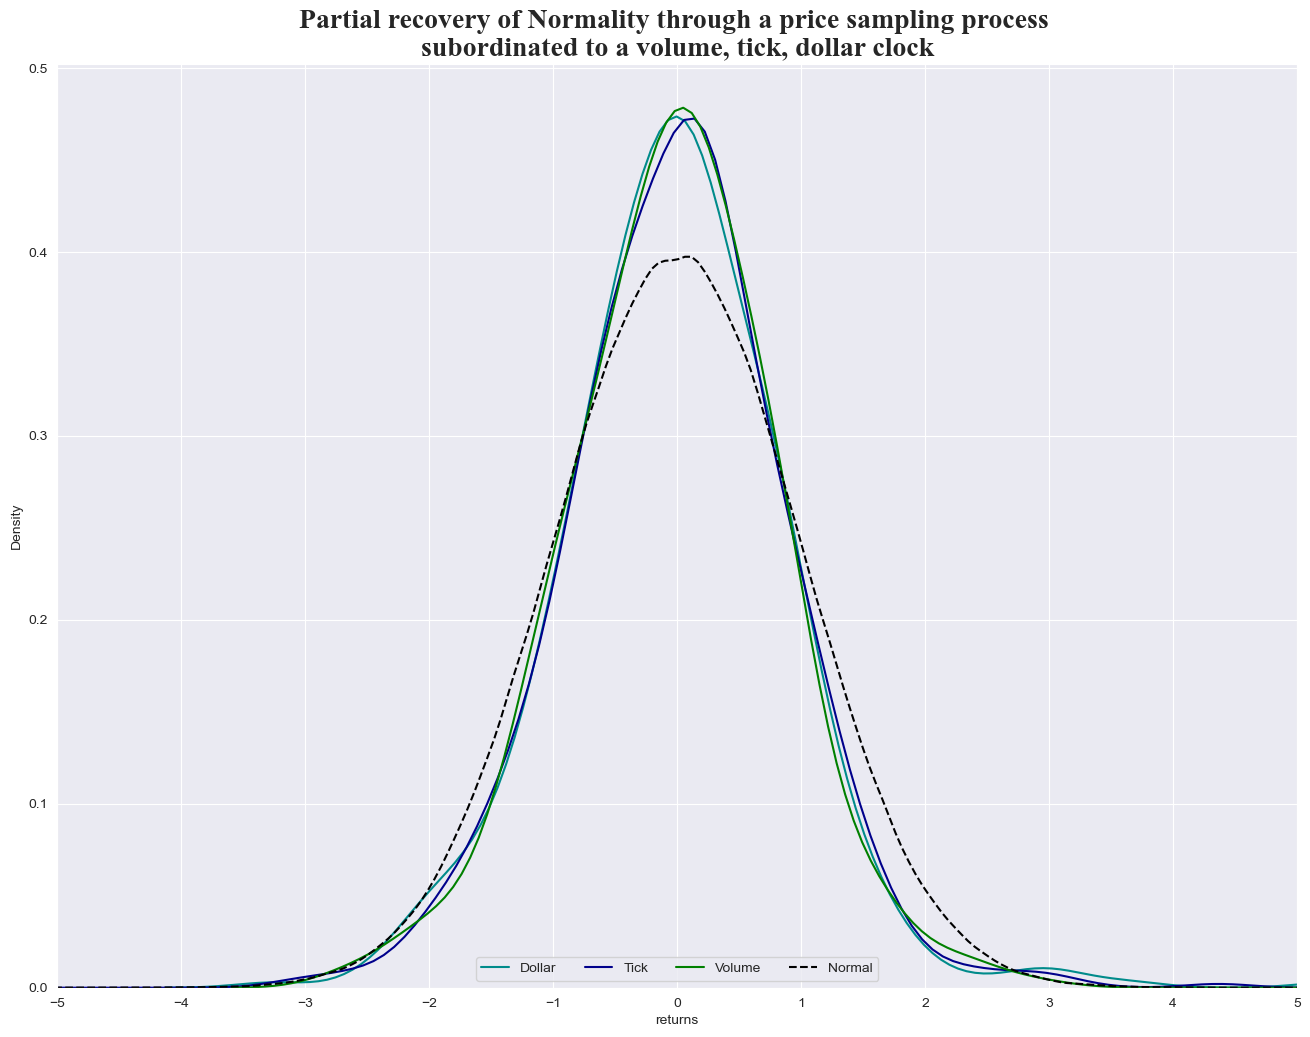

<Figure size 640x480 with 0 Axes>

In [36]:
# plotting the distributions of returns for each continuous contract on the same plot

# Ensure the returns columns are clean
continuous_dollar_relative_method['returns'].dropna(inplace=True)
continuous_tick_relative_method['returns'].dropna(inplace=True)
continuous_volume_relative_method['returns'].dropna(inplace=True)

# Standardize the returns
dollar_standard = (continuous_dollar_relative_method['returns'] - continuous_dollar_relative_method['returns'].mean()) / continuous_dollar_relative_method['returns'].std()
tick_standard = (continuous_tick_relative_method['returns'] - continuous_tick_relative_method['returns'].mean()) / continuous_tick_relative_method['returns'].std()
volume_standard = (continuous_volume_relative_method['returns'] - continuous_volume_relative_method['returns'].mean()) / continuous_volume_relative_method['returns'].std()

# Plotting the distributions
plt.figure(figsize=(16, 12))

# Dollar returns distribution
sns.kdeplot(dollar_standard, label="Dollar", color='darkcyan')

# Tick returns distribution
sns.kdeplot(tick_standard, label="Tick", color='darkblue')

# Volume returns distribution
sns.kdeplot(volume_standard, label="Volume", color='green')

# Normal distribution for comparison
sns.kdeplot(np.random.normal(size=1000000), label="Normal", color='black', linestyle="--")

plt.xticks(range(-5, 6))
plt.legend(loc=8, ncol=5)
plt.title('Partial recovery of Normality through a price sampling process \nsubordinated to a volume, tick, dollar clock',
          loc='center', fontsize=20, fontweight="bold", fontname="Times New Roman")
plt.xlim(-5, 5)
plt.show()


